## Bond dimension testing
Using two-site gradient based training with numpy svd, I found MPSs tended to 'inflate' to the max bond dimension, unless a very high cutoff (~1e-2) was set. Want to check if that's still the case with the stable SVD code, and if so, how it might be avoided.

In [1]:
import numpy as np
import torch

from models import MPS, ComplexTensor
from utils import build_ghz_plus
from qtools import pauli_exp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from utils import MeasurementDataset,do_local_sgd_training, evaluate
import matplotlib.pyplot as plt
import datetime

Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=4
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

The ground truth state (a ghz state with no phase)

In [6]:
ghz_plus = build_ghz_plus(L)
ghz_plus.to(device=dev)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [7]:
# fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
# fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
Nsamp=20000
samples = np.load(fname_samples)[:Nsamp]
samples_tr = torch.tensor((1-samples)/2).to(dtype=torch.long,device=dev)
settings = np.load(fname_settings)[:Nsamp]

In [8]:
theta = torch.tensor(settings[...,0],dtype=torch.float32,device=dev)
phi = torch.tensor(settings[...,1],dtype=torch.float32,device=dev)

Holds the unitaries corresponding to each angle

In [9]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

A dataset which yields outcomes and corresponding rotations

In [10]:
Ntr=18000

In [11]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)
ds_tr, ds_val = random_split(ds, [Ntr, Nsamp-Ntr])

Batch size and learning rate for training:

In [12]:
batch_size = 1028
lr = 5e-3

Number of epochs of training

In [13]:
epochs = 25

How many grad-descent steps to perform at each bond

In [14]:
nstep=1

Max number of singular values to keep, and cutoff below which to truncate singular values

In [15]:
max_sv = 10
cutoff=1e-3

Regularization term: penalty for Renyi-2 entropy, here set to zero

In [16]:
def make_linear_schedule(start, finish, epochs):
    def f(ep):
        return start + ep * (finish - start) / (epochs-1)
    return f

def make_exp_schedule(start, timescale):
    def f(ep):
        return start * np.exp(- ep / timescale)
    return f

In [17]:
s2_penalty = make_exp_schedule(1.0, epochs//5) 
max_sv_to_keep = lambda ep: max_sv


In [18]:
model, logdict = evaluate(ds_tr, ds_val, lr, batch_size,epochs, s2_penalty=s2_penalty, 
                                    cutoff=cutoff, max_sv_to_keep=max_sv_to_keep, use_cache=True, 
                                   verbose=True)

Training on system size 4 with 18000 samples
Finished epoch 0 in 0.632 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 1 in 0.633 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 2 in 0.614 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 3 in 0.616 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 4 in 0.615 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 5 in 0.617 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 6 in 0.616 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 7 in 0.601 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 8 in 0.611 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 9 in 0.615 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 10 in 0.617 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 11 in 0.615 sec
Model shape:  [(1, 2), (2, 3), (3, 2), (2, 1)]
Finished epoch 12 in 0.630 se

In [19]:
fidelity = logdict['fidelity']
loss = logdict['loss']
max_bond_dim = logdict['max_bond_dim']
eigs = logdict['eigenvalues']
s2 = logdict['s2']
val_loss = logdict['val_loss']

In [20]:
t = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

Text(0.5,1,'batch NLL loss 2019-05-06_14:24:28')

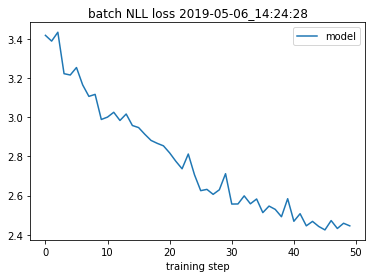

In [21]:
%matplotlib inline
fig, ax = plt.subplots()
plt.plot(loss, label='training set')
plt.plot(val_loss, label='val set')
plt.legend()
plt.xlabel("training step")
plt.title("batch NLL loss %s" % t)
# fig.savefig("assets/nll_loss_example_{0}.png".format(t))